# How to extract Historical Data from a Drift device

As it was already [explained](../panda_drift.md), _PANDA|Drift_ keep a history of input data that might be images from CV cameras, sensor data or metrics.
In this tutorial we learn:

1. How to connect a Drift device and explore topics
2. Download and parse a Drift Package
3. Extract an image from a CV camera
4. Extract time series from an acceleration sensor
5. Get metrics

## Connect and explore topics

To connect to a device, you need to know its hostname or IP address and password:

In [199]:
import os
from drift_client import DriftClient

drift_client = DriftClient("drift-test-rig.local", os.getenv("DRIFT_PASSWORD"))

print(drift_client.get_topics())

['acc-0', 'acc-1', 'acc-2', 'acc-3', 'acc-4', 'acc-5', 'acc-6', 'acc-7', 'camera', 'energy-distr-0', 'energy-distr-1', 'energy-distr-2', 'energy-distr-3', 'energy-distr-4', 'energy-distr-5', 'energy-distr-6', 'energy-distr-7']


You can see that the Drift device has few topics. Unfortunately, the device doesn't provide information about the type, and you should know it in advance. Here we have 8 acceleration signals (time series), 8  energy distributions (metrics of accelerations) and one camera (images).

## Download and parse a Drift package
When you know a topic name you can load some bulk of packages for a time interval. Let's take packages of camera data for the last 5 seconds:

In [200]:
from datetime import datetime, timedelta

package_names = drift_client.get_package_names(
    "camera", datetime.utcnow() - timedelta(seconds=5), datetime.utcnow()
)
print(f"Found {len(package_names)} packages")
print(package_names)

Found 4 packages
['camera/1661947950323.dp', 'camera/1661947951323.dp', 'camera/1661947952325.dp', 'camera/1661947953325.dp']


We should take ~5 packages because we capture an image each second. Let's download one from our object storage and parse it:

In [201]:
pkg = drift_client.get_item(package_names[0])
print(f"Download package id={pkg.package_id} status={pkg.status_code}")

Download package id=1661947950323 status=0


All packages have at least an `ID` and `status code`. The package ID is unique for a topic, it is a timestamp when an event in the system happened. If you know that topic 'A' has metrics for data from topic 'B' they will have the same IDs, so that you can align data from different topics that belong to the same event. A package has the status code 0 if it has valid data.

Because we download a Drift package it always contains [WaveletBuffer](https://github.com/panda-official/WaveletBuffer). Let's take it and play a bit with:

In [202]:
buffer = pkg.as_buffer()
print(buffer)

WaveletBuffer<signal_number=3, signal_shape=(1920x1200), decomposition_steps=4, wavelet_type=WaveletType.DB3>


## Extract an image from a CV camera
From the previous step, we see that the buffer has some meta information about itself, and we can see that it has fullHD 3-channeled picture. We can extract it as a numpy array:

Scaled image (3, 600, 960)


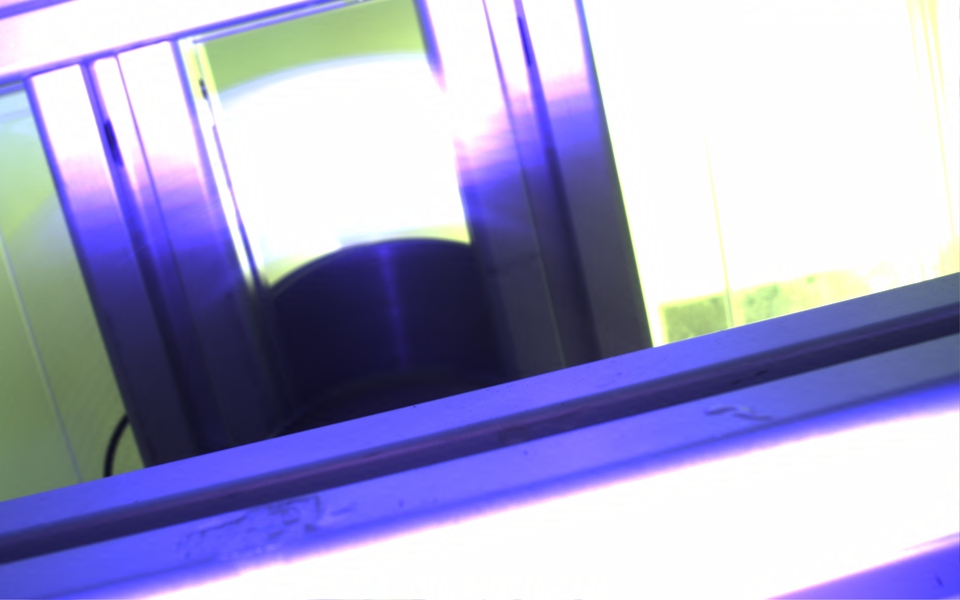

In [203]:
from wavelet_buffer.img import RgbJpeg, GrayJpeg
from IPython.display import Image

pic = buffer.compose(
    scale_factor=1
)  # we may use scale factor and restore 2^scaler_factor times smaller version of image

print(f"Scaled image {pic.shape}")
jpeg = RgbJpeg().encode(pic)
Image(data=jpeg)

## Extract time series from an acceleration sensor
We can also use the wavelet decomposition for time series data when we have very high sample rate (vibration or sound e.g). In our demo system we have 8 acceleration service `acc-{0..7}`. Let's take one of them and show what is inside:

In [204]:
package_names = drift_client.get_package_names(
    "acc-1", datetime.utcnow() - timedelta(seconds=5), datetime.utcnow()
)
pkg = drift_client.get_item(package_names[0])
buffer = pkg.as_buffer()
print(buffer)

WaveletBuffer<signal_number=1, signal_shape=(48150), decomposition_steps=9, wavelet_type=WaveletType.DB3>


The buffer contains a timeseries with ~48k points, we can show its smaller version:

Scaled size (376,)


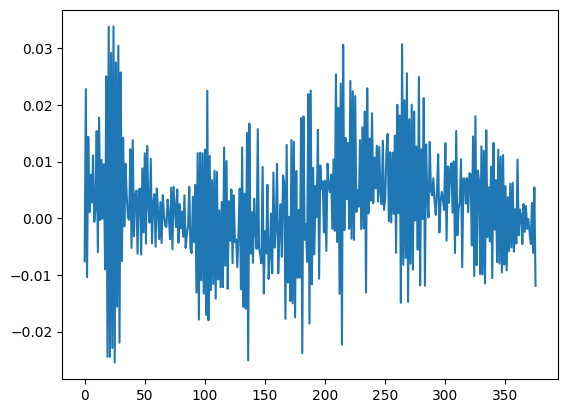

In [209]:
signal = buffer.compose(scale_factor=7)
print(f"Scaled size {signal.shape}")

import matplotlib.pyplot as plt

plt.plot(signal)
plt.show()

## Get metrics
The _PANDA|Drift_ platform keep a history of metrics differently than input data. So, a user should use different API to get them.

In our example, we have energy distribution (like frequency spectrum) of  the acceleration senors as metrics. We can use `get_metrics` method to upload them:

In [206]:
metrics = drift_client.get_metrics(
    "energy-distr-1",
    start=datetime.utcnow() - timedelta(seconds=3),
    stop=datetime.utcnow()
)

print(metrics)

[{'a9': 3.044073, 'count': 11, 'd1': 1.3450315, 'd2': 19.749475, 'd3': 29.71214, 'd4': 44.56265, 'd5': 98.17867, 'd6': 138.82454, 'd7': 41.264793, 'd8': 9.322096, 'd9': 1.3829287, 'status': 0, 'total': 387.38638, 'time': 1661947954.325}, {'a9': 5.343266, 'count': 11, 'd1': 1.3569103, 'd2': 20.422777, 'd3': 29.383175, 'd4': 60.052788, 'd5': 152.26677, 'd6': 208.83202, 'd7': 162.98158, 'd8': 24.403963, 'd9': 1.7730702, 'status': 0, 'total': 666.8163, 'time': 1661947955.325}]


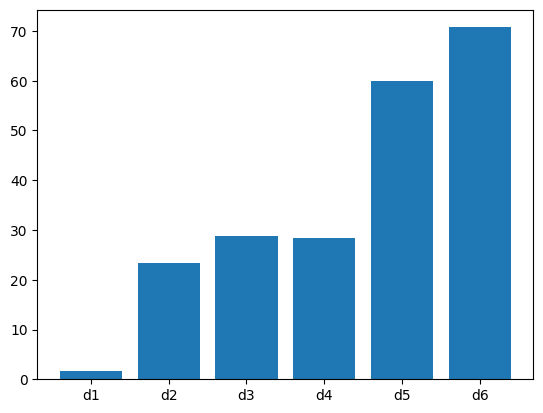

In [207]:
energies = drift_client.get_metrics(
    "energy-distr-1",
    start=datetime.utcnow() - timedelta(seconds=5),
    stop=datetime.utcnow(),
    names=["d1", "d2", "d3", "d4", "d5", "d6"]
)

as_dict = dict(energies[0])
as_dict.pop("time")
plt.bar(as_dict.keys(), as_dict.values())
plt.show()